# Relax Take Home Challenge 




In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
# import data
users_df = pd.read_csv('data/takehome_users.csv')
user_eng_df = pd.read_csv('data/takehome_user_engagement.csv')

In [3]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
# examin users_df data
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
user_eng_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
# examin user_eng_df data
user_eng_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
# check for missing 
users_df.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [8]:
user_eng_df.isna().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [9]:
users_df.duplicated().sum()

0

In [10]:
user_eng_df.duplicated().sum()

0

The users dataframe has two features with missing values. The engaged data has none and there are no duplicates in either data set.



In [11]:
# fill missing values
users_df.invited_by_user_id.fillna(0,inplace=True)


In [12]:
# missing values in last_session_creation_time ...
# see if there are any logins for these users
users_df.object_id[users_df.last_session_creation_time.isna()].unique() in user_eng_df.user_id.unique()


<ipython-input-12-bf3bcda61cdb>:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  users_df.object_id[users_df.last_session_creation_time.isna()].unique() in user_eng_df.user_id.unique()


False

It would seem that out of 12000 users we have no logins for 3177. Either we have a mistake or 26.5% of users created accounts and never logged in. We'll be dropping this column anyway but its good to keep in mind. 

First we'll aggregate by day so we are not counting multiple logins in the same day. Then we'll group by 7 day periods.


In [13]:
# convert to datetime
user_eng_df['time_stamp'] = pd.to_datetime(user_eng_df['time_stamp'])
user_eng_df.visited.unique()

array([1])

In [14]:
#group by day seting each day to min since all visites are 1 
login_days = user_eng_df.set_index('time_stamp').groupby(['user_id', pd.Grouper( freq='1D')]).min()

In [15]:
#group sum of visits in 7 days
login_days.reset_index(inplace=True)
visits7day = login_days.set_index('time_stamp').groupby(['user_id', pd.Grouper( freq='7D')]).sum()

In [16]:
#reset index and check unique visits
visits7day.reset_index(inplace=True)
visits7day.visited.unique()

array([1, 2, 3, 4, 5, 6, 7])

We'll add the adopted users feature to the users data as a binary feature with 1 indicating they have logged in 3 days in 7 days

In [17]:
# add adopted user feature to users data as 0 for all then set the selected users to 1
users_df['adopted_user'] = 0

for user in visits7day.loc[ visits7day.visited >= 3]['user_id'].unique():
    users_df.loc[users_df.object_id == user, 'adopted_user'] =1

In [18]:
print(users_df.adopted_user.sum(), 'users are considered adopted')

1445 users are considered adopted


That is 12% of accounts that are adopted.
If we count at only the users we have login records for its 16.4%

Before we drop unnessicary columns lets check them out a little further.

In [19]:
users_df.name.duplicated().sum()

651

In [20]:
users_df.email[users_df.email.duplicated()].unique()

array(['JaninaSankt@gmail.com', 'AlfieLane@yahoo.com',
       'KlausMueller@gustr.com', 'MaximilianWalter@gmail.com',
       'JacobTye@gmail.com', 'MagnusSWinther@jourrapide.com',
       'KristinKappel@yahoo.com', 'LaerkeMBertelsen@gmail.com',
       'UlrikeGerste@gmail.com', 'MandySchroder@gustr.com',
       'LasseLNrgaard@gmail.com', 'MarkoSeiler@yahoo.com',
       'ThomasBrandt@gmail.com', 'MimirMKarlsen@jourrapide.com',
       'AmandaABach@gmail.com', 'TomSchiffer@gmail.com',
       'NicolaiSHolm@yahoo.com', 'KerstinNeudorf@gmail.com',
       'PaigeWyatt@gmail.com', 'LeonieDuerr@gmail.com'], dtype=object)

In [21]:
users_df[users_df.email.duplicated()]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
3605,3606,2013-05-10 08:31:59,Sankt Janina,JaninaSankt@gmail.com,GUEST_INVITE,1.369816e+09,0,0,84,8356.0,0
3822,3823,2012-11-22 05:51:29,Lane Alfie,AlfieLane@yahoo.com,ORG_INVITE,1.353650e+09,0,0,169,9498.0,0
4955,4956,2013-01-28 23:21:34,Mueller Klaus,KlausMueller@gustr.com,GUEST_INVITE,1.359415e+09,1,0,19,3225.0,0
5016,5017,2013-01-18 02:12:58,Walter Maximilian,MaximilianWalter@gmail.com,SIGNUP_GOOGLE_AUTH,1.358562e+09,1,1,402,0.0,0
5081,5082,2013-06-25 19:31:11,Tye Jacob,JacobTye@gmail.com,SIGNUP_GOOGLE_AUTH,1.372361e+09,0,0,298,0.0,0
6346,6347,2014-04-14 07:58:54,Winther Magnus,MagnusSWinther@jourrapide.com,SIGNUP,1.397549e+09,0,0,51,0.0,0
6432,6433,2014-05-09 10:31:42,Kappel Kristin,KristinKappel@yahoo.com,SIGNUP,1.399804e+09,1,1,202,0.0,0
6536,6537,2014-05-09 00:19:37,Bertelsen L�rke,LaerkeMBertelsen@gmail.com,PERSONAL_PROJECTS,NaN,1,1,127,0.0,0
6705,6706,2012-06-27 06:19:12,Gerste Ulrike,UlrikeGerste@gmail.com,SIGNUP_GOOGLE_AUTH,1.340778e+09,0,1,333,0.0,0
7159,7160,2012-11-15 03:13:19,Schr�der Mandy,MandySchroder@gustr.com,PERSONAL_PROJECTS,NaN,1,0,127,0.0,0


In [22]:
users_df.object_id.duplicated().sum()

0

We have duplicated names and emails... Names could be real still but emails there shouldn't be multiple accounts with the same email address.

At this point I'd like to drop all the questionable data. However we don't have a lot of data to start with and over 1/4th of the data has no logins. Keeping it may mean garbage in garbage out. 

Random forest might be able to get something with a the small data set since it will bootstrap the data.


We'll drop duplicated emails and the columns that won't help a model.



In [48]:
users_df.object_id[users_df.last_session_creation_time.isna()]

7            8
8            9
11          12
14          15
15          16
         ...  
11975    11976
11977    11978
11984    11985
11992    11993
11993    11994
Name: object_id, Length: 3177, dtype: int64

In [51]:
users_df_small = users_df.drop(users_df.object_id[users_df.last_session_creation_time.isna()].index, axis=0)
users_df_small = users_df_small.drop(users_df_small[users_df_small.email.duplicated()].index, axis=0)

#columns to drop
to_drop = ['object_id', 'creation_time', 'name', 'email', 'last_session_creation_time']

users_df_small.drop(to_drop, axis=1, inplace=True)


In [23]:
users_df_drop = users_df.drop(users_df[users_df.email.duplicated()].index, axis=0)

#columns to drop
to_drop = ['object_id', 'creation_time', 'name', 'email', 'last_session_creation_time']

users_df_drop.drop(to_drop, axis=1, inplace=True)

In [27]:
users_df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11980 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             11980 non-null  object 
 1   opted_in_to_mailing_list    11980 non-null  int64  
 2   enabled_for_marketing_drip  11980 non-null  int64  
 3   org_id                      11980 non-null  int64  
 4   invited_by_user_id          11980 non-null  float64
 5   adopted_user                11980 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 655.2+ KB


<AxesSubplot:xlabel='creation_source', ylabel='count'>

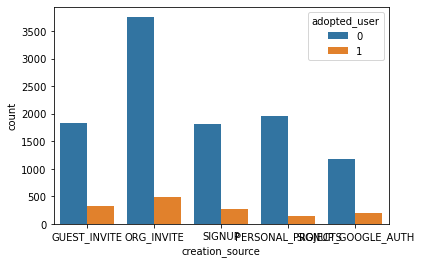

In [29]:
sns.countplot(x= 'creation_source', data= users_df_drop, hue= 'adopted_user')

<AxesSubplot:xlabel='opted_in_to_mailing_list', ylabel='count'>

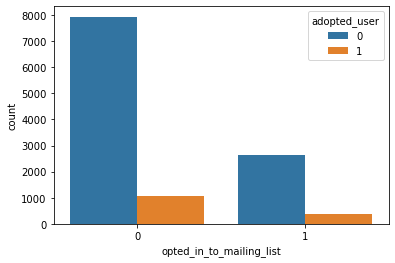

In [25]:
sns.countplot(x= 'opted_in_to_mailing_list', data= users_df_drop, hue= 'adopted_user')

<AxesSubplot:xlabel='enabled_for_marketing_drip', ylabel='count'>

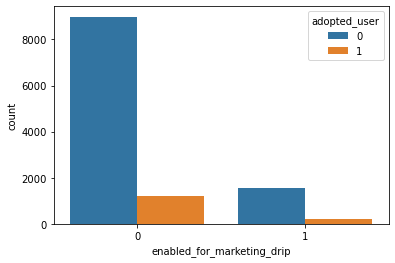

In [26]:
sns.countplot(x= 'enabled_for_marketing_drip', data= users_df_drop, hue= 'adopted_user')

<AxesSubplot:xlabel='org_id', ylabel='count'>

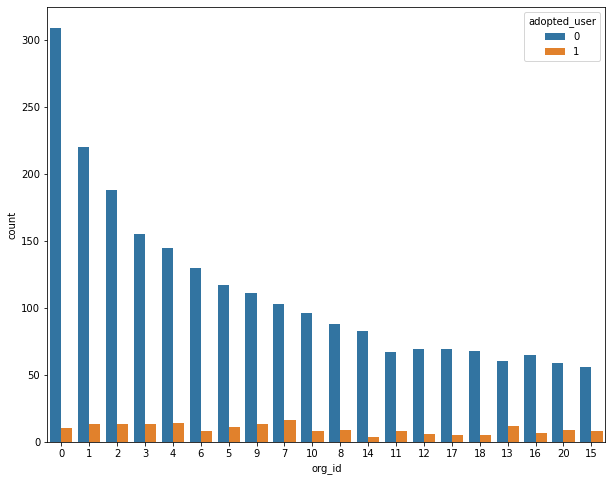

In [42]:
fig = plt.figure(figsize=(10,8))
sns.countplot(x= 'org_id', data= users_df_drop, order= users_df_drop.org_id.value_counts().iloc[:20].index, hue= 'adopted_user')


<AxesSubplot:xlabel='org_id', ylabel='count'>

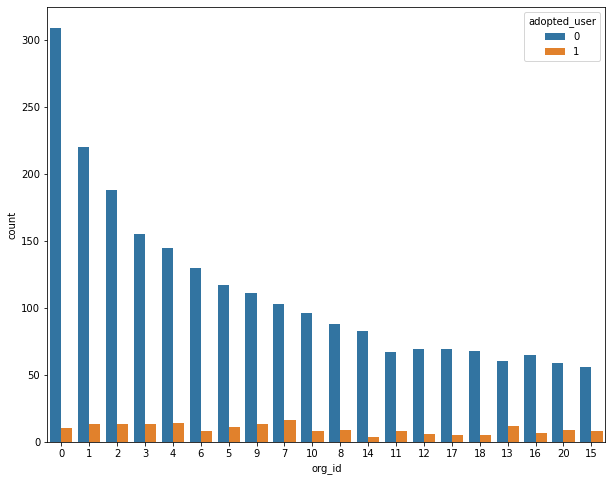

In [41]:
fig = plt.figure(figsize=(10,8))
sns.countplot(x= 'org_id', data= users_df_drop,hue= 'adopted_user', order= users_df_drop.org_id.value_counts().iloc[:20].index)


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from  sklearn.model_selection import GridSearchCV

In [45]:
X = users_df_drop.drop('adopted_user', axis=1)
y = users_df_drop['adopted_user']

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=68)

In [46]:
RFC_params = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10],
}
RF = RandomForestClassifier(random_state=68)
RFGS = GridSearchCV(RF, RFC_params)
RFGS.fit(X_train, y_train)
RFGS.best_params_

{'max_depth': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 200}

In [47]:
rf = RandomForestClassifier(max_depth= 10,
                            min_samples_leaf= 10,
                            min_samples_split= 2,
                            n_estimators= 200,
                            random_state=68)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      3168
           1       0.00      0.00      0.00       426

    accuracy                           0.88      3594
   macro avg       0.44      0.50      0.47      3594
weighted avg       0.78      0.88      0.83      3594



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
X = users_df_small.drop('adopted_user', axis=1)
y = users_df_small['adopted_user']

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=68)

In [ ]:
RFC_params = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10],
}
RF = RandomForestClassifier(random_state=68)
RFGS = GridSearchCV(RF, RFC_params)
RFGS.fit(X_train, y_train)
RFGS.best_params_

In [ ]:
rf = RandomForestClassifier(max_depth= 10,
                            min_samples_leaf= 10,
                            min_samples_split= 2,
                            n_estimators= 200,
                            random_state=68)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))